In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import scipy

In [7]:
V_na_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/gru_l20_h40_0.2ms_test_V.npy")
V_nona_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/gru_l20_h40_0.2ms_test_V.npy")
V_comb_pred = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V.npy")
V_whole_pred = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy")
V_ap_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_0.2ms_test_V.npy")

spk = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].flatten()

V_na_true_next = np.zeros((20,50000))
V_nona_true_next = np.zeros((20,50000))
V_comb_pred_next = np.zeros((20,50000))
V_whole_pred_next = np.zeros((20,50000))
V_ap_true_next = np.zeros((20,50000))

V_na_true_next[:,:-1] = V_na_true[:,1:]
V_nona_true_next[:,:-1] = V_nona_true[:,1:]
V_comb_pred_next[:,:-1] = V_comb_pred[:,1:]
V_whole_pred_next[:,:-1] = V_whole_pred[:,1:]
V_ap_true_next[:,:-1] = V_ap_true[:,1:]

In [8]:
thresh_list = np.arange(10,20)
bin_size = 4 * 5
na_true_pr = np.empty((thresh_list.shape[0], 2))
nona_true_pr = np.empty((thresh_list.shape[0], 2))
comb_pred_pr = np.empty((thresh_list.shape[0], 2))
whole_pred_pr = np.empty((thresh_list.shape[0], 2))
ap_true_pr = np.empty((thresh_list.shape[0], 2))

for n in tnrange(5):
    if n == 0:
        V = V_na_true
        V_next = V_na_true_next
    elif n == 1:
        V = V_nona_true
        V_next = V_nona_true_next
    elif n == 2:
        V = V_comb_pred
        V_next = V_comb_pred_next
    elif n == 3:
        V = V_whole_pred
        V_next = V_whole_pred_next
    elif n == 4:
        V = V_ap_true
        V_next = V_ap_true_next
        
    for i in range(thresh_list.shape[0]):
        thresh = thresh_list[i]
        S = np.zeros((20,50000))
        
        for j in range(20):
            idx = np.where((V[j] < thresh) & (V_next[j] >= thresh))[0]
            S[j,idx] = 1

        prob_bin = scipy.ndimage.convolve1d(S.reshape(20,50000), np.ones((bin_size)), 1)
        prob_bin = prob_bin[:,bin_size-1:-bin_size+1]
        prob_bin[prob_bin>0] = 1
        spk_bin = scipy.ndimage.convolve1d(spk.reshape(20,50000), np.ones((bin_size)), 1)
        spk_bin = spk_bin[:,bin_size-1:-bin_size+1]
        spk_bin[spk_bin>0] = 1

        tp = np.where((prob_bin == 1) & (spk_bin == 1))[0].size
        fp = np.where((prob_bin == 1) & (spk_bin == 0))[0].size
        tn = np.where((prob_bin == 0) & (spk_bin == 0))[0].size
        fn = np.where((prob_bin == 0) & (spk_bin == 1))[0].size
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        if n == 0:
            na_true_pr[i,0] = prec
            na_true_pr[i,1] = rec
        elif n == 1:
            nona_true_pr[i,0] = prec
            nona_true_pr[i,1] = rec
        elif n == 2:
            comb_pred_pr[i,0] = prec
            comb_pred_pr[i,1] = rec
        elif n == 3:
            whole_pred_pr[i,0] = prec
            whole_pred_pr[i,1] = rec
        elif n == 4:
            ap_true_pr[i,0] = prec
            ap_true_pr[i,1] = rec

<ipython-input-8-8b3666104174>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n in tnrange(5):


  0%|          | 0/5 [00:00<?, ?it/s]

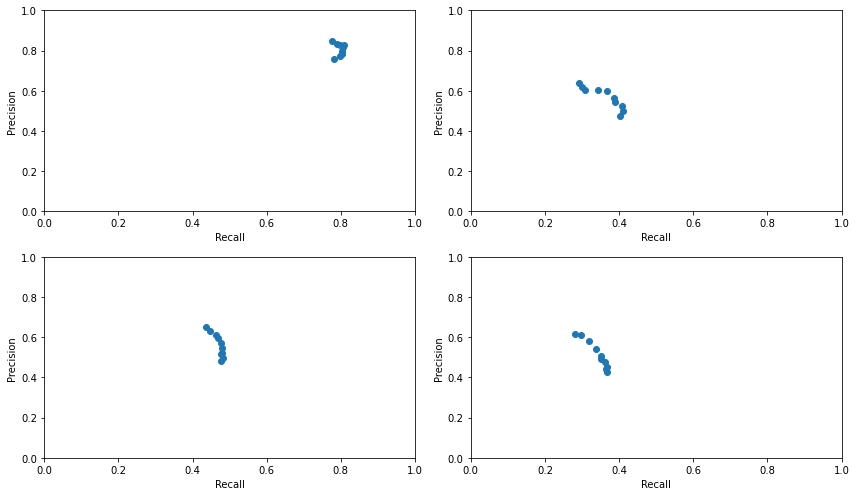

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

for row in range(2):
    for col in range(2):
        idx = row*2+col
        if idx == 0:
            axs[row,col].scatter(na_true_pr[:,1],
                          na_true_pr[:,0])
        elif idx == 1:
            axs[row,col].scatter(nona_true_pr[:,1],
                          nona_true_pr[:,0])
        elif idx == 2:
            axs[row,col].scatter(comb_pred_pr[:,1],
                          comb_pred_pr[:,0])
        elif idx == 3:
            axs[row,col].scatter(whole_pred_pr[:,1],
                          whole_pred_pr[:,0])
            
        axs[row,col].set_xlabel("Recall")
        axs[row,col].set_ylabel("Precision")
        axs[row,col].set_xlim(0,1)
        axs[row,col].set_ylim(0,1)
        
#axs[0,0].set_title("sub-threshold 0.2ms")
#axs[0,1].set_title("sub-threshold 0.4ms")
#axs[1,0].set_title("sub-threshold 1ms")
#axs[1,1].set_title("sub-threshold 2ms")

fig.tight_layout()



In [10]:
print("AP True", ap_true_pr[6,1], ap_true_pr[6,0])
print("Na True", na_true_pr[6,1], na_true_pr[6,0])
print("No Na True", nona_true_pr[6,1], nona_true_pr[6,0])
print("Comb Pred", comb_pred_pr[6,1], comb_pred_pr[6,0])
print("Whole Pred", whole_pred_pr[6,1], whole_pred_pr[6,0])

AP True 0.9156565656565656 0.9156565656565656
Na True 0.8085858585858586 0.8295336787564767
No Na True 0.34393939393939393 0.6026548672566372
Comb Pred 0.4686868686868687 0.5948717948717949
Whole Pred 0.3388888888888889 0.5413473174667205


In [11]:
V_ap_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_0.2ms_test_V.npy")
V_na_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/gru_l20_h40_0.2ms_test_V.npy")
V_nona_true = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/gru_l20_h40_0.2ms_test_V.npy")
V_comb_pred = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V.npy")
V_whole_pred = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy")
spk = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].reshape(20,50000)

V_ap_true_next = np.zeros((20,50000))
V_na_true_next = np.zeros((20,50000))
V_nona_true_next = np.zeros((20,50000))
V_comb_pred_next = np.zeros((20,50000))
V_whole_pred_next = np.zeros((20,50000))

V_ap_true_next[:,:-1] = V_ap_true[:,1:]
V_na_true_next[:,:-1] = V_na_true[:,1:]
V_nona_true_next[:,:-1] = V_nona_true[:,1:]
V_comb_pred_next[:,:-1] = V_comb_pred[:,1:]
V_whole_pred_next[:,:-1] = V_whole_pred[:,1:]

ap_true_coinc = np.zeros((20,))
na_true_coinc = np.zeros((20,))
nona_true_coinc = np.zeros((20,))
comb_pred_coinc = np.zeros((20,))
whole_pred_coinc = np.zeros((20,))
thresh = 15
window = 4 * 5
T = 50000

for n in range(5):
    if n == 0:
        V = V_ap_true
        V_next = V_ap_true_next
    elif n == 1:
        V = V_na_true
        V_next = V_na_true_next
    elif n == 2:
        V = V_nona_true
        V_next = V_nona_true_next
    elif n == 3:
        V = V_comb_pred
        V_next = V_comb_pred_next
    elif n == 4:
        V = V_whole_pred
        V_next = V_whole_pred_next
    
    S = np.zeros((20,50000))
    
    for i in range(20):
        idx = np.where((V[i] < thresh) & (V_next[i] >= thresh))[0]
        S[i,idx] = 1
    
    pred_bin = scipy.ndimage.convolve1d(S.reshape(20,50000), np.ones((window)), 1)
    pred_bin = pred_bin[:,window-1:-window+1]
    pred_bin[pred_bin>0] = 1
    spk_bin = scipy.ndimage.convolve1d(spk.reshape(20,50000), np.ones((window)), 1)
    spk_bin = spk_bin[:,window-1:-window+1]
    spk_bin[spk_bin>0] = 1
            
    for i in range(20):
        N_n = int(np.sum(spk[i]))
        N_m = int(np.sum(S[i]))
        #N_pois = 2 * window * N_n * N_m / T
        #N_nm = np.where((pred_bin[i] == 1) & (spk_bin[i] == 1))[0].size
        #coinc = (N_nm - N_pois) / (0.5*(1-N_pois/N_n)*(N_n+N_m))
        
        N_coinc = np.where((pred_bin[i] == 1) & (spk_bin[i] == 1))[0].size
        N_pois = 2 * window * N_n * N_m / T
        N = 1 - 2*N_m/T*window
        coinc = (N_coinc - N_pois)/(0.5*(N_n+N_m))/(N)
        
        if n == 0:
            ap_true_coinc[i] = coinc
        elif n == 1:
            na_true_coinc[i] = coinc
        elif n == 2:
            nona_true_coinc[i] = coinc
        elif n == 3:
            comb_pred_coinc[i] = coinc
        elif n == 4:
            whole_pred_coinc[i] = coinc
            

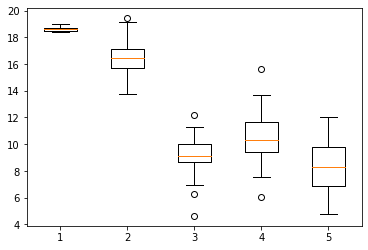

In [13]:
coinc_all = np.zeros((20,5))
coinc_all[:,0] = ap_true_coinc
coinc_all[:,1] = na_true_coinc
coinc_all[:,2] = nona_true_coinc
coinc_all[:,3] = comb_pred_coinc
coinc_all[:,4] = whole_pred_coinc

plt.boxplot(coinc_all)
plt.show()

In [14]:
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/coinc_2ms_15v.npy", ap_true_coinc)
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/coinc_2ms_15v.npy", na_true_coinc)
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/coinc_2ms_15v.npy", nona_true_coinc)
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/coinc_2ms_15v.npy", comb_pred_coinc)
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/coinc_2ms_15v.npy", whole_pred_coinc)

In [3]:
ms_list = [1,2,5,10]
auc_array = np.zeros((4,13,20))

for i in tnrange(4):
    length = int(50000/ms_list[i]/5)
    ap_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    whole_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_pred_nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_noise_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_noise/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    
    spk_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_"+str(ms_list[i])+"ms.npy")[980*length:].flatten()
    
    for j in range(20):
        ap_true = ap_true_all[j*length:(j+1)*length]
        na_true = na_true_all[j*length:(j+1)*length]
        nona_true = nona_true_all[j*length:(j+1)*length]
        comb_pred = comb_pred_all[j*length:(j+1)*length]
        whole_pred = whole_pred_all[j*length:(j+1)*length]
        diff_true = diff_true_all[j*length:(j+1)*length]
        diff_pred = diff_pred_all[j*length:(j+1)*length]
        nona_pred = nona_pred_all[j*length:(j+1)*length]
        na_true_late = na_true_late_all[j*length:(j+1)*length]
        comb_pred_late = comb_pred_late_all[j*length:(j+1)*length]
        na_true_nona_pred = na_true_nona_pred_all[j*length:(j+1)*length]
        na_pred_nona_true = na_pred_nona_true_all[j*length:(j+1)*length]
        na_true_noise = na_true_noise_all[j*length:(j+1)*length]
        spk = spk_all[j*length:(j+1)*length]
        
        prec_comb_pred, rec_comb_pred, _ = precision_recall_curve(spk, comb_pred)
        prec_whole_pred, rec_whole_pred, _ = precision_recall_curve(spk, whole_pred)
        prec_ap_true, rec_ap_true, _ = precision_recall_curve(spk, ap_true)
        prec_na_true, rec_na_true, _ = precision_recall_curve(spk, na_true)
        prec_nona_true, rec_nona_true, _ = precision_recall_curve(spk, nona_true)
        prec_diff_true, rec_diff_true, _ = precision_recall_curve(spk, diff_true)
        prec_diff_pred, rec_diff_pred, _ = precision_recall_curve(spk, diff_pred)
        prec_nona_pred, rec_nona_pred, _ = precision_recall_curve(spk, nona_pred)
        prec_na_true_late, rec_na_true_late, _ = precision_recall_curve(spk, na_true_late)
        prec_comb_pred_late, rec_comb_pred_late, _ = precision_recall_curve(spk, comb_pred_late)
        prec_na_true_nona_pred, rec_na_true_nona_pred, _ = precision_recall_curve(spk, na_true_nona_pred)
        prec_na_pred_nona_true, rec_na_pred_nona_true, _ = precision_recall_curve(spk, na_pred_nona_true)
        prec_na_true_noise, rec_na_true_noise, _ = precision_recall_curve(spk, na_true_noise)

        prarea_comb_pred = metrics.auc(rec_comb_pred, prec_comb_pred)
        prarea_whole_pred = metrics.auc(rec_whole_pred, prec_whole_pred)
        prarea_ap_true = metrics.auc(rec_ap_true, prec_ap_true)
        prarea_na_true = metrics.auc(rec_na_true, prec_na_true)
        prarea_nona_true = metrics.auc(rec_nona_true, prec_nona_true)
        prarea_diff_true = metrics.auc(rec_diff_true, prec_diff_true)
        prarea_diff_pred = metrics.auc(rec_diff_pred, prec_diff_pred)
        prarea_nona_pred = metrics.auc(rec_nona_pred, prec_nona_pred)
        prarea_na_true_late = metrics.auc(rec_na_true_late, prec_na_true_late)
        prarea_comb_pred_late = metrics.auc(rec_comb_pred_late, prec_comb_pred_late)
        prarea_na_true_nona_pred = metrics.auc(rec_na_true_nona_pred, prec_na_true_nona_pred)
        prarea_na_pred_nona_true = metrics.auc(rec_na_pred_nona_true, prec_na_pred_nona_true)
        prarea_na_true_noise = metrics.auc(rec_na_true_noise, prec_na_true_noise)
        
        auc_array[i,0,j] = prarea_ap_true
        auc_array[i,1,j] = prarea_na_true
        auc_array[i,2,j] = prarea_nona_true
        auc_array[i,3,j] = prarea_comb_pred
        auc_array[i,4,j] = prarea_whole_pred
        auc_array[i,5,j] = prarea_diff_true
        auc_array[i,6,j] = prarea_diff_pred
        auc_array[i,7,j] = prarea_nona_pred
        auc_array[i,8,j] = prarea_na_true_late
        auc_array[i,9,j] = prarea_comb_pred_late
        auc_array[i,10,j] = prarea_na_true_nona_pred
        auc_array[i,11,j] = prarea_na_pred_nona_true
        auc_array[i,12,j] = prarea_na_true_noise

<ipython-input-3-b0887cb02ca1>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(4):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-5-90c9aa75c4ff>:80: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


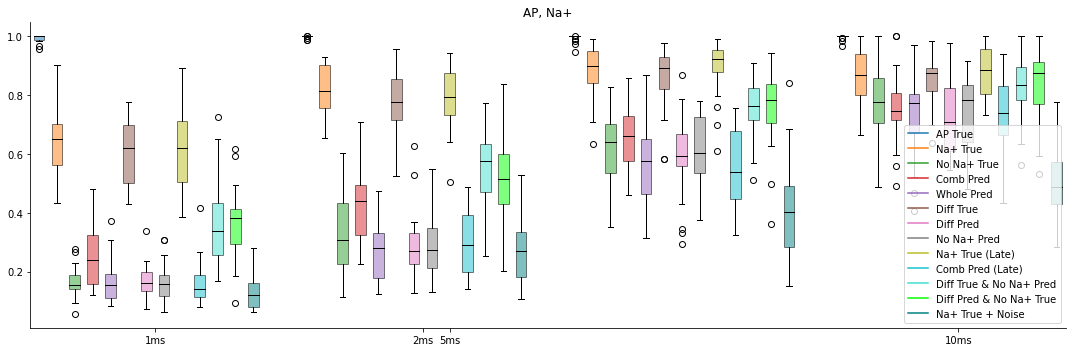

In [5]:
fig = plt.figure(constrained_layout=True, figsize = (15,5))
gs = fig.add_gridspec(1,1, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])

colors = ["tab:blue","tab:orange","tab:green",
         "tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
         "tab:olive","tab:cyan","turquoise","lime", "teal"]

# first boxplot pair
bp = ax.boxplot(auc_array[0].T, positions = np.arange(0,13,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[1].T, positions = np.arange(15,28,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[2].T, positions = np.arange(30,43,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[3].T, positions = np.arange(45,58,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
ax.set_xticks([6.5,21.5,23,51.5])
ax.set_xticklabels(["1ms", "2ms", "5ms", "10ms"])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title("AP, Na+")

h1, = ax.plot(1,1,'tab:blue')
h2, = ax.plot(1,1,'tab:orange')
h3, = ax.plot(1,1,'tab:green')
h4, = ax.plot(1,1,'tab:red')
h5, = ax.plot(1,1,'tab:purple')
h6, = ax.plot(1,1,'tab:brown')
h7, = ax.plot(1,1,'tab:pink')
h8, = ax.plot(1,1,'tab:gray')
h9, = ax.plot(1,1,'tab:olive')
h10, = ax.plot(1,1,'tab:cyan')
h11, = ax.plot(1,1,'turquoise')
h12, = ax.plot(1,1,'lime')
h13, = ax.plot(1,1,'teal')

ax.legend((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13),('AP True','Na+ True','No Na+ True','Comb Pred',
                                           'Whole Pred', 'Diff True', 'Diff Pred', 'No Na+ Pred',
                                           'Na+ True (Late)', 'Comb Pred (Late)', "Diff True & No Na+ Pred",
                                           "Diff Pred & No Na+ True", "Na+ True + Noise"))
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)
h4.set_visible(False)
h5.set_visible(False)
h6.set_visible(False)
h7.set_visible(False)
h8.set_visible(False)
h9.set_visible(False)
h10.set_visible(False)
h11.set_visible(False)
h11.set_visible(False)
h12.set_visible(False)
h13.set_visible(False)

fig.tight_layout()
plt.show()